In [1]:
# the building we want to run
building_id = 2
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 35
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "rbf-cost"
number_of_opt_evaluations = 50
run_i = 7
iteration = 37
building_id = 2
price = 106


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


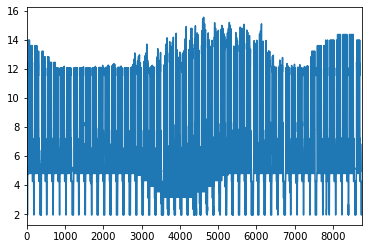

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.8591406345367432 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.8461050987243652 sec


ERROR:root:Finished Generation of Irradiance


0.0


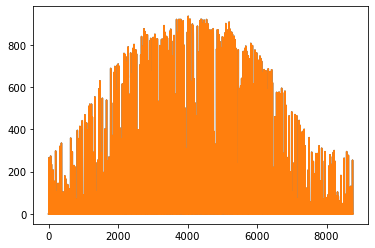

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7236831188201904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7481396198272705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.734611988067627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


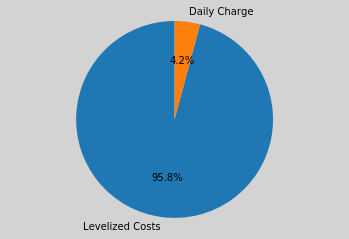

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

61845.7

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [23]:
my_model.solveResults['solution']['any_above_35']

0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

In [28]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:The number of evaluations is 50


[90.  90.  90.   1.   1.   1.   0.2  0.2  0.2] [265.  265.  265.   56.   56.   56.    0.9   0.9   0.9] ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']


ERROR:ga_logger:panel values: (137.9114252339935, 245.97040407596637, 144.47019642596086, 12.766035508608653, 51.05432394984314, 44.5438556946539, 0.3052375990791363, 0.43847591991641444, 0.6921310343281155)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 138
                                           a tilt of 12.8
                                           and a gcr of 0.305


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.866992950439453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 246
                                           a tilt of 51.1
                                           and a gcr of 0.438


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7511699199676514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 144
                                           a tilt of 44.5
                                           and a gcr of 0.692


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7528491020202637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [65.7955, 0.0, 265.229]


ERROR:ga_logger:Cost: 3420.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


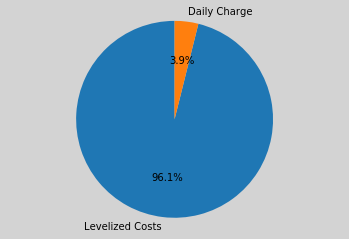

ERROR:ga_logger:panel values: (120.95236908172052, 163.18154398499163, 222.21102422491873, 30.845970285900357, 5.161392535462778, 6.395882888981659, 0.36127893468540956, 0.20087350003311016, 0.247006135160091)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 30.8
                                           and a gcr of 0.361


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7689008712768555 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 5.2
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.726633310317993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 222
                                           a tilt of 6.4
                                           and a gcr of 0.247


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7930281162261963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [216.32, 0.0, 0.0]


ERROR:ga_logger:Cost: 4786.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


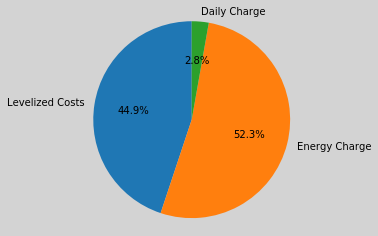

ERROR:ga_logger:panel values: (206.8330883480773, 213.21814327571082, 172.10541294818063, 54.782730224601636, 24.587467801990577, 54.063064147834716, 0.6962039544545857, 0.6509728103041806, 0.8826459569705352)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 207
                                           a tilt of 54.8
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.811551094055176 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 24.6
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.738576650619507 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 54.1
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7152981758117676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 312.531, 0.0]


ERROR:ga_logger:Cost: 3237.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


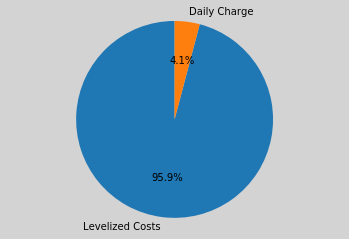

ERROR:ga_logger:panel values: (179.35749143701298, 128.38176987425885, 260.33250186355315, 3.9970722914746437, 40.287437219518424, 30.4679350184419, 0.5841592975711136, 0.8603211393314343, 0.4564213003961028)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 4.0
                                           and a gcr of 0.584


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.783428907394409 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 128
                                           a tilt of 40.3
                                           and a gcr of 0.860


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.765597343444824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 30.5
                                           and a gcr of 0.456


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.827199697494507 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [325.103, 0.0, 0.0]


ERROR:ga_logger:Cost: 3362.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


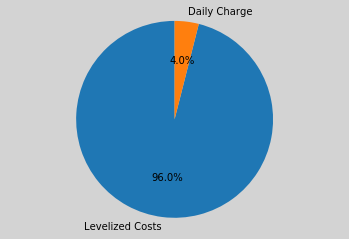

ERROR:ga_logger:panel values: (256.96792496576916, 96.60380489753364, 109.49869206794408, 39.43097696352079, 13.465673913258371, 16.766409790659477, 0.8687381012655411, 0.5422364341181998, 0.5348958334077698)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 257
                                           a tilt of 39.4
                                           and a gcr of 0.869


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8364953994750977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 13.5
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.784949541091919 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 109
                                           a tilt of 16.8
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.735419750213623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 320.275]


ERROR:ga_logger:Cost: 3517.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


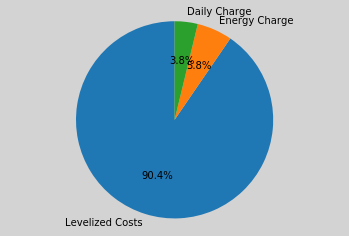

ERROR:ga_logger:panel values: (177.5, 177.5, 177.5, 28.5, 28.5, 28.5, 0.5499999999999999, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.771470785140991 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7564334869384766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7586913108825684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.163]


ERROR:ga_logger:Cost: 3084.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


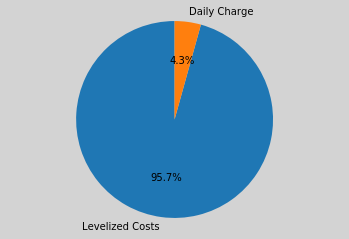

ERROR:ga_logger:panel values: (93.34807439792367, 263.3233849418581, 91.19228834462106, 55.827407415023295, 55.6364779889098, 1.0510841665615624, 0.2049066768135927, 0.8981002941327281, 0.215895660018804)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 93
                                           a tilt of 55.8
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9060423374176025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 55.6
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.766507625579834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 1.1
                                           and a gcr of 0.216


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.939685344696045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 513.406, 5.85163]


ERROR:ga_logger:Cost: 5290.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


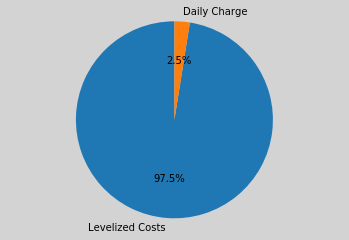

ERROR:ga_logger:panel values: (260.82179894719627, 262.871570696033, 262.7682388270424, 2.328981927288973, 2.346248324547658, 1.37137731753552, 0.8963694068425283, 0.8874366395759381, 0.8873827927274138)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 2.3
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5969982147216797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 2.3
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.61504864692688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 1.4
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.238568067550659 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.154]


ERROR:ga_logger:Cost: 3471.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


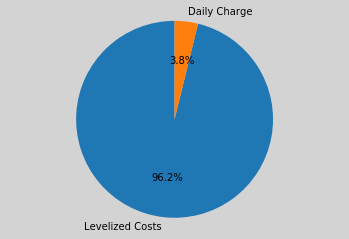

ERROR:ga_logger:panel values: (261.74215294060446, 257.480137471756, 264.9681032868408, 54.379188177461714, 55.96673716576253, 55.416754483971346, 0.8939752777885257, 0.2113495230092467, 0.20660776794303287)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 54.4
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.810695171356201 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 257
                                           a tilt of 56.0
                                           and a gcr of 0.211


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.752777576446533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 55.4
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.894714593887329 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [496.721, 9.11543, 0.0]


ERROR:ga_logger:Cost: 5157.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


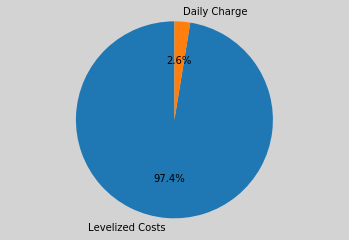

ERROR:ga_logger:panel values: (148.83364420992632, 148.81039608451738, 205.61647985362183, 37.42668877125748, 37.36880463573432, 19.960540768994566, 0.663246427027375, 0.4402980797449335, 0.6627637342903614)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 37.4
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7722251415252686 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 37.4
                                           and a gcr of 0.440


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7488718032836914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 206
                                           a tilt of 20.0
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8898110389709473 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 179.156, 127.161]


ERROR:ga_logger:Cost: 3175.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


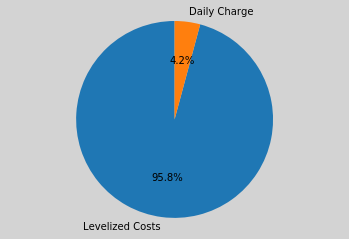

ERROR:ga_logger:panel values: (148.92282969510603, 203.98020790490915, 150.433654283038, 19.775682299778662, 19.59548615922463, 37.480459199935716, 0.6641665378809021, 0.6600677319336764, 0.43612647781183844)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 19.8
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.821640729904175 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 204
                                           a tilt of 19.6
                                           and a gcr of 0.660


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0206151008605957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 37.5
                                           and a gcr of 0.436


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.747317314147949 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 130.553, 174.875]


ERROR:ga_logger:Cost: 3166.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


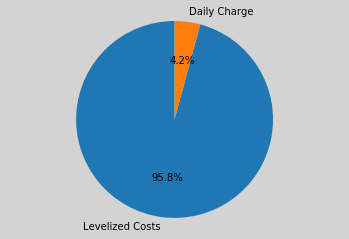

ERROR:ga_logger:panel values: (90.00000000006985, 90.00000000003458, 90.00000000006676, 1.000000000009197, 18.951281497558494, 55.99999999998426, 0.8999999999997934, 0.8999999999991208, 0.8999999999999351)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.8982179164886475 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 19.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.734954833984375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7488086223602295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [335.991, 0.0, 0.0]


ERROR:ga_logger:Cost: 3470.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


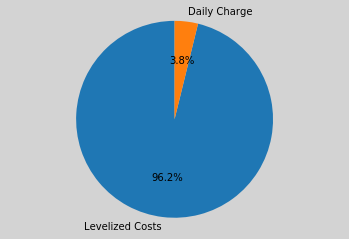

ERROR:ga_logger:panel values: (259.5957309273864, 177.76725895195275, 90.62400573003727, 1.0603438540039225, 55.54608303606574, 8.270954113613081, 0.8969785364953642, 0.8960181472567597, 0.8927667667335981)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 1.1
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.0530426502227783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 55.5
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.071829319000244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 8.3
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0622875690460205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 169 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [335.984, 0.0, 0.0]


ERROR:ga_logger:Cost: 3470.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


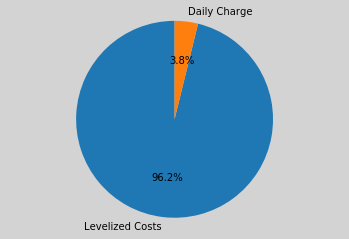

ERROR:ga_logger:panel values: (262.16042688472277, 114.25296130541129, 209.10371539285092, 3.556873149231556, 1.5776567543341664, 55.96042537827748, 0.8419813023383342, 0.7266605562291579, 0.8943888691074338)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 3.6
                                           and a gcr of 0.842


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6929404735565186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 1.6
                                           and a gcr of 0.727


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3543448448181152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 209
                                           a tilt of 56.0
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.191540002822876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 182 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 333.857, 0.0]


ERROR:ga_logger:Cost: 3448.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


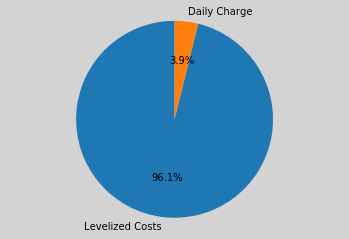

ERROR:ga_logger:panel values: (129.28191455386155, 213.7398865496778, 225.00009880768997, 7.751252361140097, 30.09563954688853, 17.769371640846504, 0.8724806436677901, 0.8529191589611516, 0.8947015649988839)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 129
                                           a tilt of 7.8
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6296584606170654 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 214
                                           a tilt of 30.1
                                           and a gcr of 0.853


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.210509777069092 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 17.8
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3987796306610107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [329.526, 0.0, 0.0]


ERROR:ga_logger:Cost: 3405.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


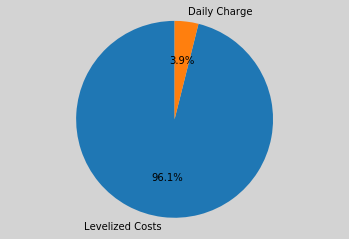

ERROR:ga_logger:panel values: (188.80531657997437, 149.0124824114517, 148.8758495046994, 19.464287345458423, 35.92417771999093, 37.368115445951595, 0.5896029013145913, 0.6608240830934047, 0.6649175675316983)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 19.5
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7231624126434326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 35.9
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4680676460266113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 37.4
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4483351707458496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 189 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [301.818, 0.0, 0.0]


ERROR:ga_logger:Cost: 3130.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


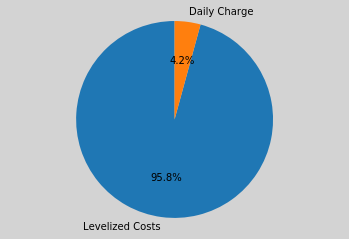

ERROR:ga_logger:panel values: (165.7786367479064, 182.2727196058147, 172.8114233559781, 24.248566579844578, 22.22397686886036, 34.530116331762436, 0.6064139635079757, 0.6250927263622628, 0.665185566093359)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 24.2
                                           and a gcr of 0.606


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3509886264801025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 22.2
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4394874572753906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 34.5
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4282445907592773 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 300.066, 0.0]


ERROR:ga_logger:Cost: 3113.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


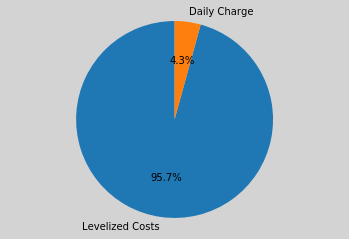

ERROR:ga_logger:panel values: (178.16332635331332, 152.05361071477415, 185.62174772886914, 31.420959663234836, 35.924926048456484, 28.86422212584127, 0.6065060974650818, 0.5460652017222909, 0.8265078018766641)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 31.4
                                           and a gcr of 0.607


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.664881706237793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 35.9
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2631711959838867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 28.9
                                           and a gcr of 0.827


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.290250778198242 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [299.667, 0.0, 0.0]


ERROR:ga_logger:Cost: 3109.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


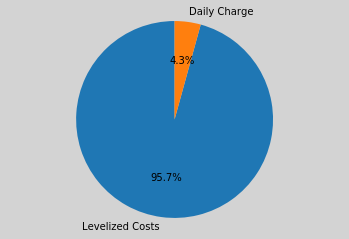

ERROR:ga_logger:panel values: (261.8383514840085, 260.24958775829737, 90.86929579476335, 6.834887671072575, 4.400349873311744, 38.31308882063843, 0.8864958159916088, 0.8816388486328588, 0.8869171466328369)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 6.8
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.836578845977783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 4.4
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1782546043395996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 38.3
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.099013090133667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 337.446, 0.0]


ERROR:ga_logger:Cost: 3484.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


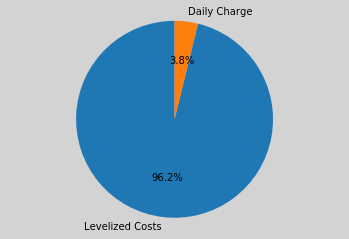

ERROR:ga_logger:panel values: (90.43269077685522, 102.95705242476689, 94.2181971106853, 55.63652728092309, 53.98499139641116, 53.31247927694965, 0.8744990571779794, 0.816130457265859, 0.8930714287856267)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 55.6
                                           and a gcr of 0.874


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.123666763305664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 103
                                           a tilt of 54.0
                                           and a gcr of 0.816


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.082247734069824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 53.3
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.165048837661743 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 466.897, 0.0]


ERROR:ga_logger:Cost: 4770.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


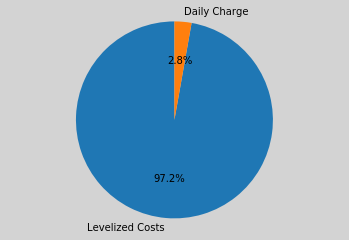

ERROR:ga_logger:panel values: (260.8224224383365, 224.52482776336663, 175.15508011604945, 1.149633380947144, 36.60508174242285, 3.1896103163149627, 0.7431144900679274, 0.36647646836862735, 0.8897296794480332)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 1.1
                                           and a gcr of 0.743


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7786061763763428 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 36.6
                                           and a gcr of 0.366


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1315572261810303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 3.2
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0044302940368652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 147.881, 173.711]


ERROR:ga_logger:Cost: 3327.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


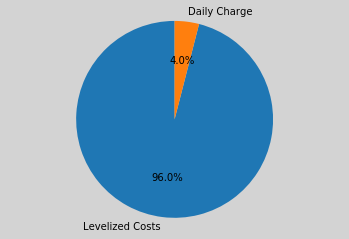

ERROR:ga_logger:panel values: (206.3060779258771, 174.32909456889715, 188.0933546922879, 19.795998173788107, 37.361793358196714, 20.525275287631587, 0.658285173575476, 0.5696076599980231, 0.6633238806647554)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 206
                                           a tilt of 19.8
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4465434551239014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 37.4
                                           and a gcr of 0.570


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0947554111480713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 20.5
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.098846912384033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [0.0, 300.869, 0.0]


ERROR:ga_logger:Cost: 3121.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


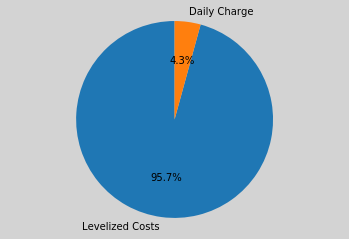

ERROR:ga_logger:panel values: (185.39016202066756, 168.26019004782125, 178.43617616170945, 23.79332555950881, 30.51210491803073, 28.633631602965455, 0.5878591892273339, 0.5332249204589049, 0.6650659911941179)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 23.8
                                           and a gcr of 0.588


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2477355003356934 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 168
                                           a tilt of 30.5
                                           and a gcr of 0.533


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1793460845947266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 28.6
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.194624662399292 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 297.926, 0.0]


ERROR:ga_logger:Cost: 3092.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


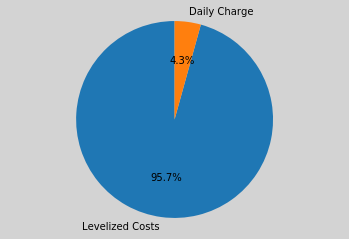

ERROR:ga_logger:panel values: (184.11399666183019, 178.07581980902694, 176.91800719236218, 27.422842662248367, 29.033645561352063, 29.708550034357593, 0.563723356922009, 0.5894400745128834, 0.5955203065330841)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 184
                                           a tilt of 27.4
                                           and a gcr of 0.564


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1093227863311768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 29.0
                                           and a gcr of 0.589


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0991785526275635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 29.7
                                           and a gcr of 0.596


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0932564735412598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [296.855, 0.0, 0.0]


ERROR:ga_logger:Cost: 3081.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


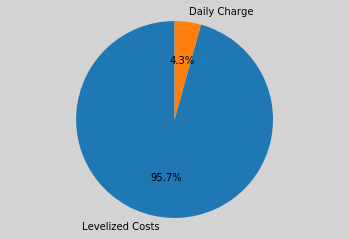

ERROR:ga_logger:panel values: (175.36908863580865, 191.7214397905359, 198.79080580185402, 23.854163580816646, 34.64771806639662, 34.9518307785127, 0.5065612432762732, 0.5831064081576918, 0.5952910278198467)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 23.9
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1612088680267334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 34.6
                                           and a gcr of 0.583


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0944504737854004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 35.0
                                           and a gcr of 0.595


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.089712142944336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [297.143, 0.0, 0.0]


ERROR:ga_logger:Cost: 3084.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


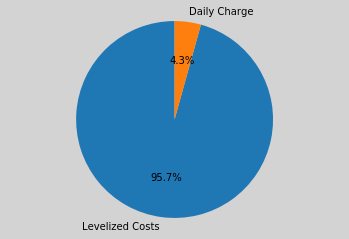

ERROR:ga_logger:panel values: (198.92040513524515, 180.8303433550041, 179.04325784204548, 29.43084415337673, 27.299490088027795, 32.06933435491635, 0.5460303577308062, 0.5641581939611753, 0.5958170231716339)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 29.4
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.348989963531494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 27.3
                                           and a gcr of 0.564


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2739808559417725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 32.1
                                           and a gcr of 0.596


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2052924633026123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 296.323, 0.0]


ERROR:ga_logger:Cost: 3076.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


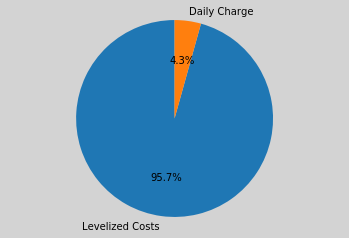

ERROR:ga_logger:panel values: (184.0784424148676, 183.38476809887322, 171.40937141497764, 27.420394353225372, 29.336288763999445, 28.807782061659914, 0.5430112476006127, 0.5853013134684358, 0.6075736453636671)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 184
                                           a tilt of 27.4
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3616816997528076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 29.3
                                           and a gcr of 0.585


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2979791164398193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 28.8
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.248905897140503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [296.238, 0.0, 0.0]


ERROR:ga_logger:Cost: 3075.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


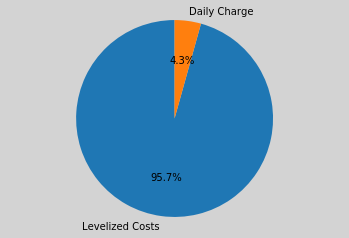

ERROR:ga_logger:panel values: (184.6315007603798, 176.27732469961455, 178.2729361572599, 27.164621642039858, 28.49297526248068, 29.175891434844914, 0.5498356046121129, 0.5952319689898455, 0.5971341324263877)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 27.2
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.349590539932251 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 28.5
                                           and a gcr of 0.595


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.229095697402954 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 29.2
                                           and a gcr of 0.597


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2774674892425537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [296.582, 0.0, 0.0]


ERROR:ga_logger:Cost: 3078.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


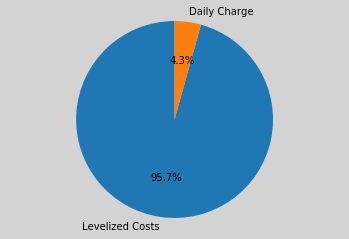

ERROR:ga_logger:panel values: (184.64214793502498, 177.07419497324864, 175.49544361958272, 27.33869590425782, 29.275456939673465, 29.94945024677353, 0.5587282560985867, 0.5910477603589493, 0.5934740906751825)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 27.3
                                           and a gcr of 0.559


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.503546714782715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 29.3
                                           and a gcr of 0.591


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3180270195007324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 29.9
                                           and a gcr of 0.593


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3383495807647705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [296.816, 0.0, 0.0]


ERROR:ga_logger:Cost: 3081.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


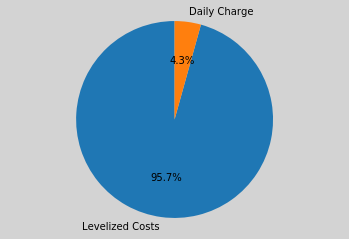

ERROR:ga_logger:panel values: (263.10539392888376, 257.5382758677495, 253.9136259492866, 19.35782838738448, 3.0834708874868064, 55.86882382664936, 0.21755971962330106, 0.8917283880763955, 0.8922396270634729)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 19.4
                                           and a gcr of 0.218


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.307436227798462 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 3.1
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0479989051818848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 254
                                           a tilt of 55.9
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1854822635650635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [0.0, 336.102, 0.0]


ERROR:ga_logger:Cost: 3471.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


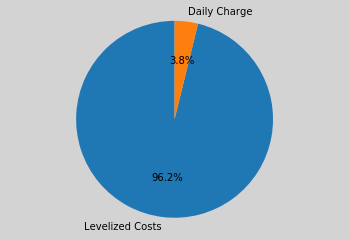

ERROR:ga_logger:panel values: (264.8822436675074, 97.33606870861524, 96.29441211602486, 1.6050502749189395, 13.121039729194658, 1.8174246709824935, 0.2247171136974975, 0.8843589374143641, 0.8956090237147079)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 1.6
                                           and a gcr of 0.225


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.134528398513794 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 13.1
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.566044330596924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 1.8
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0076329708099365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.524]


ERROR:ga_logger:Cost: 3465.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


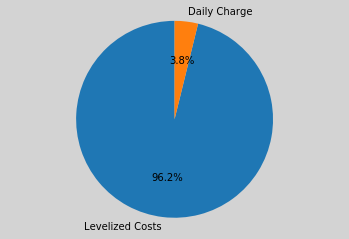

ERROR:ga_logger:panel values: (236.5103159883942, 175.93235807887805, 95.49480747288699, 1.8828618239109214, 6.572747619051629, 54.91761608971733, 0.22850925039844408, 0.8935373793044772, 0.8842143108440053)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 237
                                           a tilt of 1.9
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0773608684539795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 6.6
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.097792863845825 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 54.9
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.079133987426758 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 324.094, 0.0]


ERROR:ga_logger:Cost: 3352.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


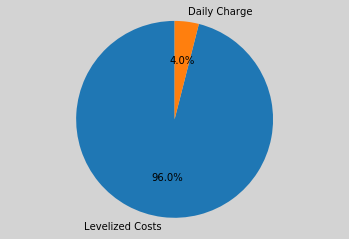

ERROR:ga_logger:panel values: (205.4718696620509, 189.57568848567033, 200.24599845429037, 35.9866255682963, 32.34381485709468, 27.628552543503613, 0.4599233252683658, 0.5567959946758836, 0.7229765419964569)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 36.0
                                           and a gcr of 0.460


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2800748348236084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 32.3
                                           and a gcr of 0.557


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1050174236297607 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 27.6
                                           and a gcr of 0.723


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1677403450012207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 298.096, 0.0]


ERROR:ga_logger:Cost: 3093.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


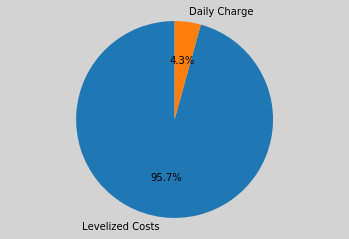

ERROR:ga_logger:panel values: (196.81904236609114, 197.7619040522548, 187.43342531123034, 27.463344457657353, 30.76637761736204, 36.246855987711534, 0.5104011586354806, 0.5837599990155821, 0.7227409902311652)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 197
                                           a tilt of 27.5
                                           and a gcr of 0.510


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5358967781066895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 198
                                           a tilt of 30.8
                                           and a gcr of 0.584


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1742138862609863 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 187
                                           a tilt of 36.2
                                           and a gcr of 0.723


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.18615460395813 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [298.672, 0.0, 0.0]


ERROR:ga_logger:Cost: 3099.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


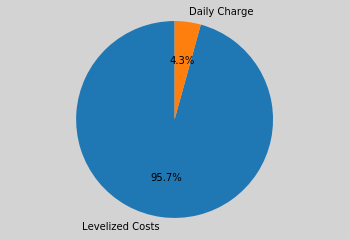

ERROR:ga_logger:panel values: (189.7565340148176, 173.2047193510254, 197.48846546438455, 32.71176994502246, 31.937383010852553, 26.726824765160018, 0.5617002330924257, 0.5378849129905992, 0.7170776179642677)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 32.7
                                           and a gcr of 0.562


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3503055572509766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 31.9
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.113865852355957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 26.7
                                           and a gcr of 0.717


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1984024047851562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 297.386, 0.0]


ERROR:ga_logger:Cost: 3086.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


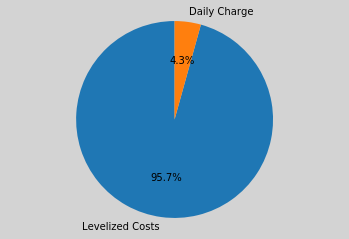

ERROR:ga_logger:panel values: (262.37404292980153, 116.53679512959779, 261.2095727868324, 54.990462582522326, 2.3115013564764517, 20.20331066223894, 0.8067485710394993, 0.8927085042494054, 0.896981249646922)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 55.0
                                           and a gcr of 0.807


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2950761318206787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 117
                                           a tilt of 2.3
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0135724544525146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 20.2
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.385282278060913 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 333.375, 0.0]


ERROR:ga_logger:Cost: 3444.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


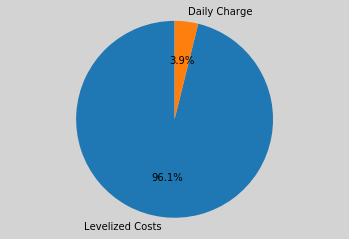

ERROR:ga_logger:panel values: (155.77535671622584, 91.26670788806098, 105.71385378361289, 2.0831718818265657, 11.278604926281066, 5.189116097413477, 0.7970883897381438, 0.6068984689196337, 0.8960997190636022)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 2.1
                                           and a gcr of 0.797


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1693575382232666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 11.3
                                           and a gcr of 0.607


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.101633071899414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 106
                                           a tilt of 5.2
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.174381732940674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [330.602, 0.0, 0.0]


ERROR:ga_logger:Cost: 3416.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


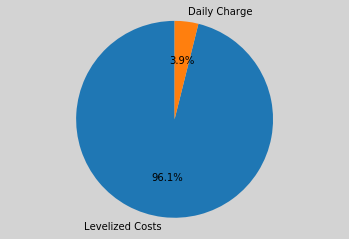

ERROR:ga_logger:panel values: (262.41600978109136, 114.22053156705229, 190.2964759075714, 1.5040179845609365, 54.81120213266231, 21.31414143764793, 0.238789596712831, 0.7297799543237156, 0.8816637497558169)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 1.5
                                           and a gcr of 0.239


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2093448638916016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 54.8
                                           and a gcr of 0.730


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2167294025421143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 21.3
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.198030710220337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 318.271]


ERROR:ga_logger:Cost: 3294.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


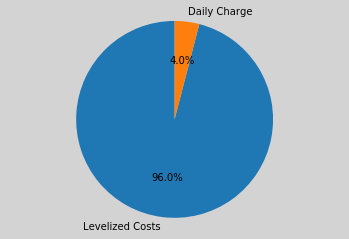

ERROR:ga_logger:panel values: (185.7768984829382, 183.70387126041228, 162.8636634110092, 18.783651818500914, 29.907172300419013, 37.00903564645581, 0.4461448856491692, 0.6372676702199899, 0.5819778736483199)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 18.8
                                           and a gcr of 0.446


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3617095947265625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 29.9
                                           and a gcr of 0.637


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.112837076187134 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 163
                                           a tilt of 37.0
                                           and a gcr of 0.582


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.235264778137207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [191.011, 108.734, 0.0]


ERROR:ga_logger:Cost: 3110.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


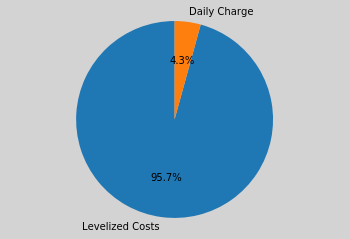

ERROR:ga_logger:panel values: (182.28683586715894, 187.66720573498822, 184.40577608261566, 23.717882322083852, 32.283795191479946, 31.961673136749184, 0.5380054993277573, 0.5858988738339301, 0.6108531647370219)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 23.7
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3613035678863525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 32.3
                                           and a gcr of 0.586


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.141505718231201 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 32.0
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1279308795928955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [297.06, 0.0, 0.0]


ERROR:ga_logger:Cost: 3083.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


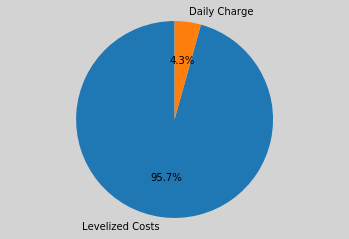

ERROR:ga_logger:panel values: (192.01296568164327, 181.73976365936713, 176.783319897648, 29.479201875344128, 28.338625806408874, 30.1520525035685, 0.5328174156288712, 0.5707960965053565, 0.6149701873847699)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 29.5
                                           and a gcr of 0.533


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4053077697753906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 28.3
                                           and a gcr of 0.571


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3196773529052734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 30.2
                                           and a gcr of 0.615


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1314797401428223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 296.55, 0.0]


ERROR:ga_logger:Cost: 3078.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


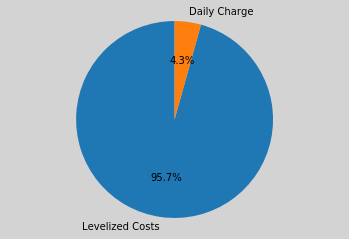

ERROR:ga_logger:panel values: (264.7160371167878, 94.17598659620613, 92.06148251429038, 1.2274481781628457, 6.650536995493515, 38.80096670243821, 0.46250469287432466, 0.23231004957363055, 0.8914809232205632)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 1.2
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.125101089477539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 94
                                           a tilt of 6.7
                                           and a gcr of 0.232


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1150689125061035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 38.8
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.185147285461426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [138.064, 0.0, 267.666]


ERROR:ga_logger:Cost: 4162.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


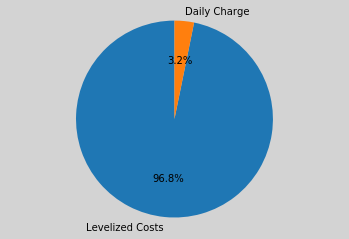

ERROR:ga_logger:panel values: (264.1359888178873, 234.71663032896643, 138.5326183745819, 26.531192403089022, 10.442057222640791, 1.5354304579868707, 0.480375750775062, 0.8942661605015185, 0.8958032649435159)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 26.5
                                           and a gcr of 0.480


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.533034324645996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 10.4
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3192338943481445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 139
                                           a tilt of 1.5
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0460455417633057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 131 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 332.836]


ERROR:ga_logger:Cost: 3438.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


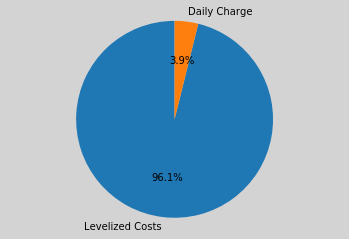

ERROR:ga_logger:panel values: (261.8410191361321, 103.84663706849264, 206.48918508917313, 2.9551841203399114, 18.96159117297632, 3.969205754578576, 0.7568680989184646, 0.8991507224606436, 0.8554403581218737)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 3.0
                                           and a gcr of 0.757


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3917832374572754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 104
                                           a tilt of 19.0
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1325643062591553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 206
                                           a tilt of 4.0
                                           and a gcr of 0.855


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1412582397460938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 327.688]


ERROR:ga_logger:Cost: 3387.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


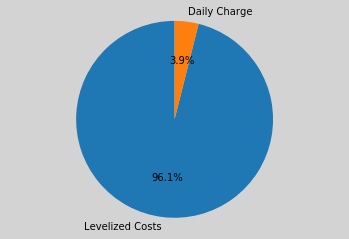

ERROR:ga_logger:panel values: (211.58809034494703, 184.31402665172226, 185.15353248708334, 35.745682195409344, 21.728814728656555, 35.576682228359154, 0.5698352967177834, 0.6439900357606039, 0.6502808775804807)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 212
                                           a tilt of 35.7
                                           and a gcr of 0.570


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.424741506576538 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 21.7
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2115776538848877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 35.6
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.177410364151001 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 301.287, 0.0]


ERROR:ga_logger:Cost: 3125.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


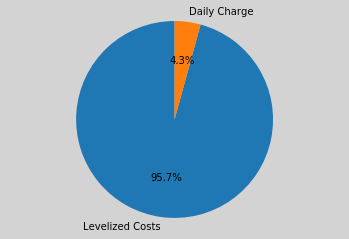

ERROR:ga_logger:panel values: (181.00581940146864, 178.15693685612843, 199.20946170337703, 25.321163773523505, 36.63506565273837, 29.56707055255767, 0.5150974519363134, 0.5912860582244073, 0.7116204254356089)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 25.3
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5490355491638184 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 36.6
                                           and a gcr of 0.591


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1676723957061768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 29.6
                                           and a gcr of 0.712


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.166018486022949 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [295.693, 0.0, 0.0]


ERROR:ga_logger:Cost: 3069.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


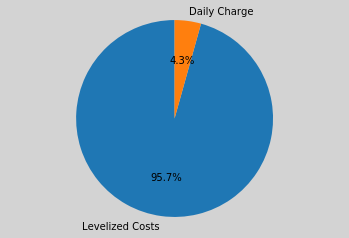

ERROR:ga_logger:panel values: (182.0996035295969, 180.13424498653592, 199.43146778378193, 25.647426207547245, 37.256358900186825, 28.56738064216173, 0.5013891747035952, 0.5997647724729132, 0.7169583029043349)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 25.6
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.976088762283325 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 37.3
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1682181358337402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 28.6
                                           and a gcr of 0.717


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1711695194244385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [295.41, 0.0, 0.0]


ERROR:ga_logger:Cost: 3067.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


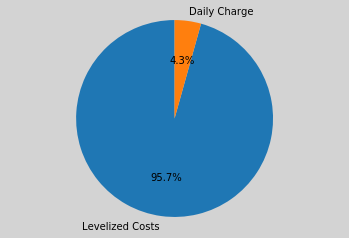

ERROR:ga_logger:panel values: (177.3797899397527, 169.45850371293142, 184.3985859831277, 29.97457406275261, 45.13456841629332, 29.980748247107442, 0.5129570534545911, 0.6653209207346501, 0.7047407406898012)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 177
                                           a tilt of 30.0
                                           and a gcr of 0.513


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4097273349761963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 45.1
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1394059658050537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 30.0
                                           and a gcr of 0.705


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1694438457489014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [295.841, 0.0, 0.0]


ERROR:ga_logger:Cost: 3071.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


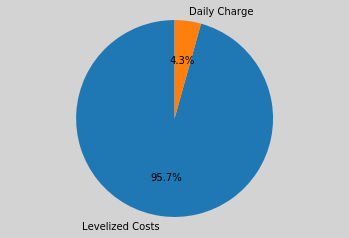

ERROR:ga_logger:panel values: (168.98846031409238, 183.11741026120774, 197.98298073237373, 25.685035032437977, 35.01064067438476, 27.859150762755533, 0.49013114367779587, 0.6325412498148815, 0.7473038802981504)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 169
                                           a tilt of 25.7
                                           and a gcr of 0.490


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.421039581298828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 35.0
                                           and a gcr of 0.633


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.191342353820801 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 27.9
                                           and a gcr of 0.747


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1478240489959717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [281.758, 15.1175, 0.0]


ERROR:ga_logger:Cost: 3081.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


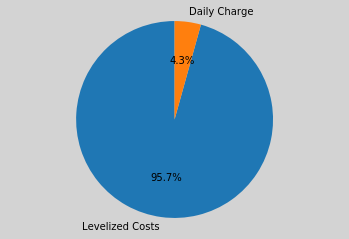

ERROR:ga_logger:panel values: (186.05677041467465, 177.9779432080444, 197.13799299526283, 25.77889304860518, 36.662118092641414, 30.126026486589282, 0.47856841818288615, 0.59967588709574, 0.7271198620601778)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 25.8
                                           and a gcr of 0.479


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4004125595092773 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 36.7
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.105588436126709 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 30.1
                                           and a gcr of 0.727


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.141587257385254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [247.35, 49.1179, 0.0]


ERROR:ga_logger:Cost: 3077.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


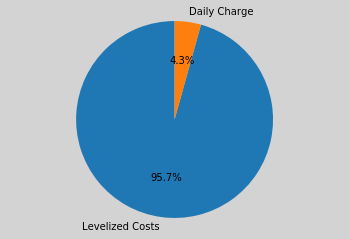

ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Run nr 7 using opt-method rbf-cost with 50 evalautions took: (min)


ERROR:Runs_logger:241.21442548831303


In [29]:
# Bonmin path
BONMIN_PATH = "/home/theochri/projects/def-revins/theochri/Bonmin/bonmin"

# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET", bonmin_path=BONMIN_PATH, rand_seed =int(run_i) )
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i))
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost-true"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i))
    pvoptimizer.processGA(ga_fina)

# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Run nr {} using opt-method {} with {} evalautions took: (min)".format(run_i,opt_method,number_of_opt_evaluations))
lrun.error(mintime)